# 1. Importación de librerías

In [ ]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, text

# Para la parte de exploración y visualización
import seaborn as sns
import matplotlib.pyplot as plt

# Para manejo de valores perdidos
from sklearn.impute import SimpleImputer

# Para codificación de variables categóricas
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Para escalado
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Para dividir el dataset en entrenamiento y prueba
from sklearn.model_selection import train_test_split

import Credentials

# 2. Extracción de los datos desde Azure data lake

In [ ]:
# Construir la URL
url = f"{Credentials.storage_account}/{Credentials.container}/{Credentials.file_path_EEUU}?{Credentials.sas_token}"

try:
    # Lee el CSV 
    df = pd.read_csv(url)
    display(df.head())
    print(df.shape)
except FileNotFoundError:
    print("Error: No se encontró el archivo en el Data Lake.")
    df = None
except Exception as e:
    print(f"Ocurrió un error: {e}")
    df = None


,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive


(4024, 16)


# 3. Exploración inicial (EDA)

Estructura de los datos: (4024, 16)

Tipo de datos:
 Age                        int64
Race                      object
Marital Status            object
T Stage                   object
N Stage                   object
6th Stage                 object
differentiate             object
Grade                     object
A Stage                   object
Tumor Size                 int64
Estrogen Status           object
Progesterone Status       object
Regional Node Examined     int64
Reginol Node Positive      int64
Survival Months            int64
Status                    object
dtype: object

Valores faltantes:
                        Count    %
Age                         0  0.0
Race                        0  0.0
Marital Status              0  0.0
T Stage                     0  0.0
N Stage                     0  0.0
6th Stage                   0  0.0
differentiate               0  0.0
Grade                       0  0.0
A Stage                     0  0.0
Tumor Size                  0  0.0


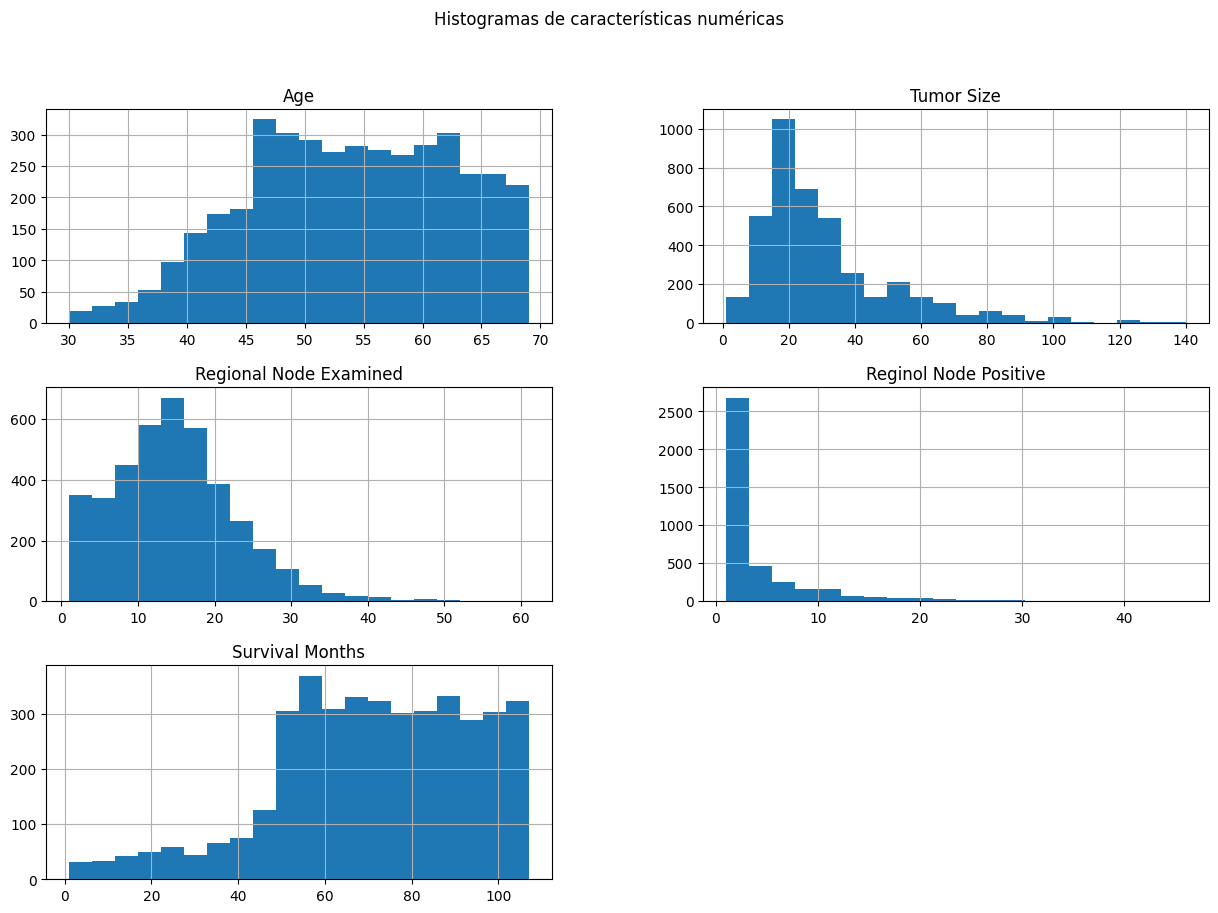

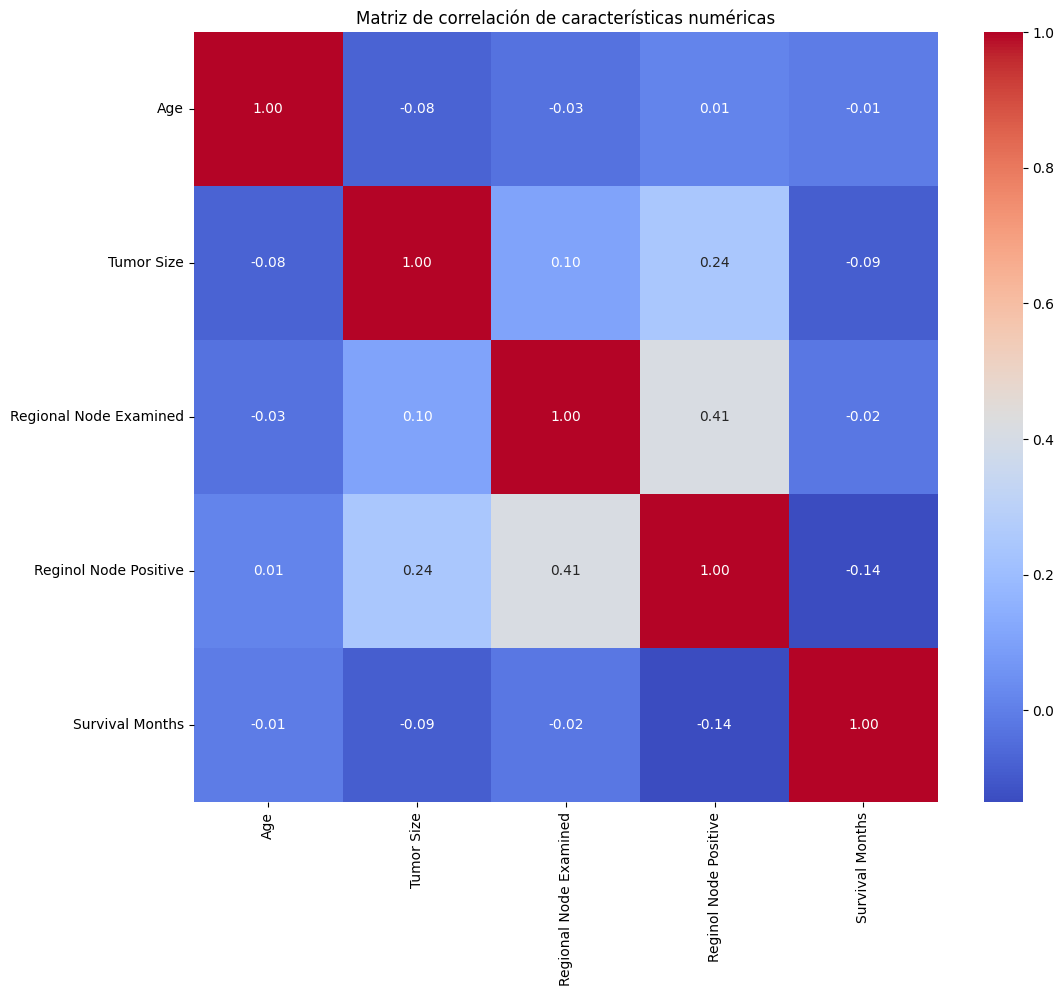

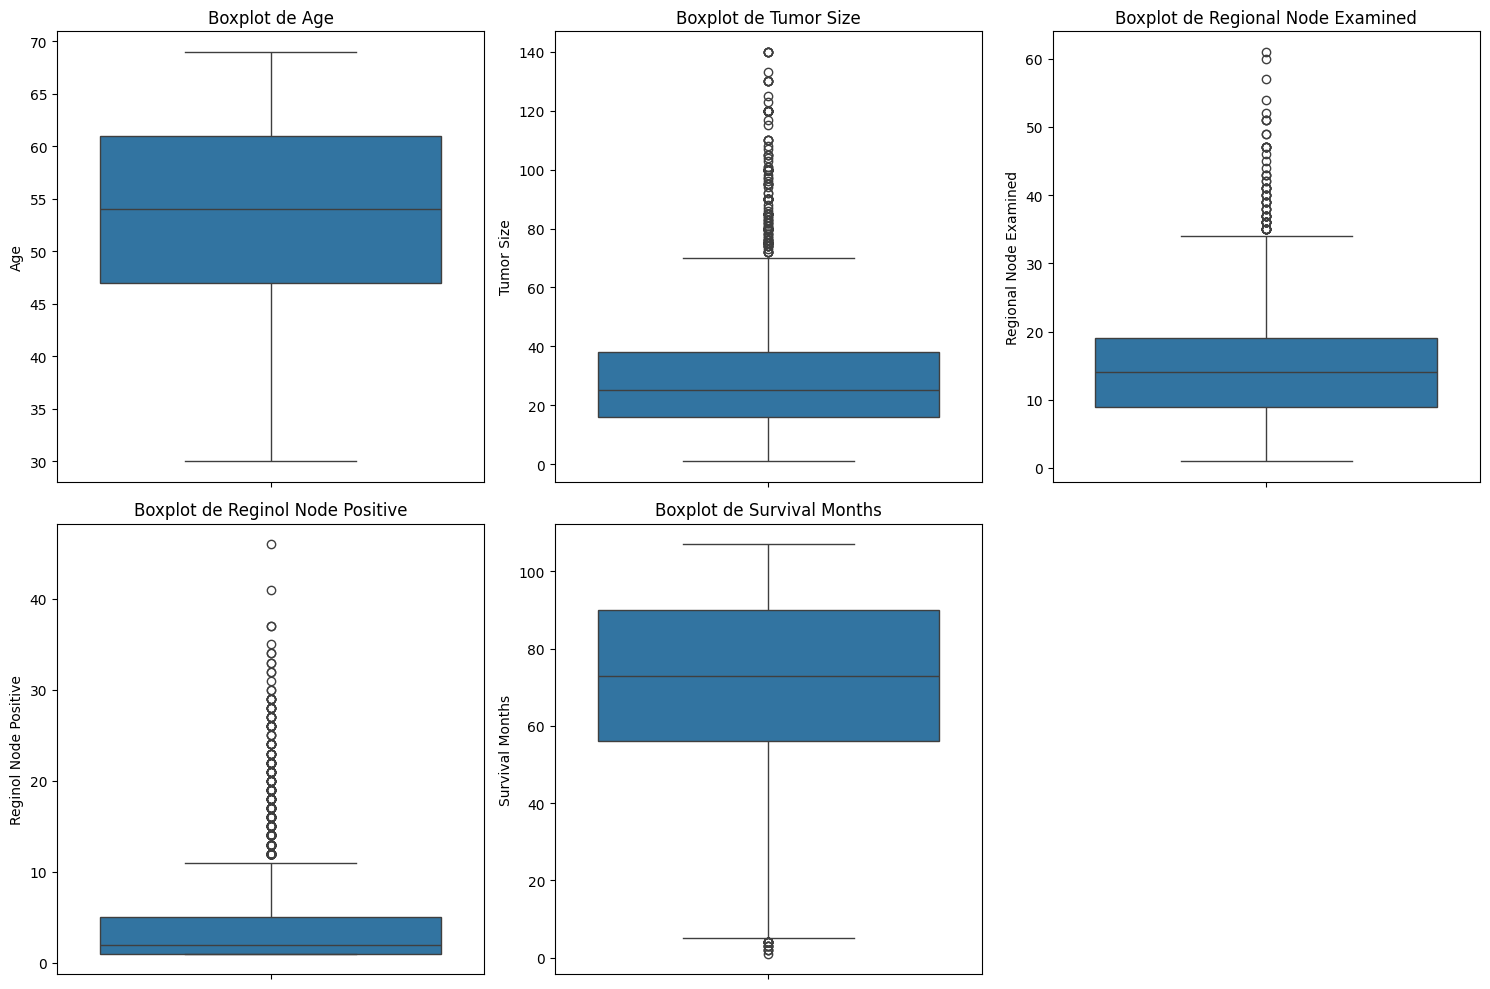

In [15]:
# Estructura y tipo de datos
print("Estructura de los datos:", df.shape)
print("\nTipo de datos:\n", df.dtypes)

# Validacion de valores faltantes
print("\nValores faltantes:")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
print(pd.concat([missing_values, missing_percentage], axis=1, keys=['Count', '%']))

# Estadísticas descriptivas
print("\nEstadísticas descriptivas:\n", df.describe(include='all'))

# Distribuciones
print("\nDiagnosis Frequency:\n", df['Status'].value_counts())
# Histogramas/Gráficos de densidad (características numéricas)
import matplotlib.pyplot as plt
numerical_features = ['Age', 'Tumor Size', 'Regional Node Examined', 'Reginol Node Positive', 'Survival Months']
df[numerical_features].hist(figsize=(15, 10), bins=20)
plt.suptitle("Histogramas de características numéricas")
plt.show()

# Analisis de correlación
numerical_df = df.select_dtypes(include=['number'])
correlation_matrix = numerical_df.corr()
plt.figure(figsize=(12, 10))
import seaborn as sns
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación de características numéricas")
plt.show()

# Deteccion de Outliers
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f"Boxplot de {col}")
plt.tight_layout()
plt.show()

# 4. Limpieza de datos

In [ ]:
# Manejo de valores atípicos
upper_limit = np.percentile(df['Tumor Size'], 95)  # Determine the 95th percentile
df['Tumor Size'] = np.clip(df['Tumor Size'], a_min=None, a_max=upper_limit)

# Verificar la consistencia de las columnas categóricas.
for col in ['Race', 'Marital Status', 'T Stage ', 'N Stage', '6th Stage', 'differentiate', 'A Stage', 'Estrogen Status', 'Progesterone Status', 'Status']:
    print(f"Valores únicos para {col}: {df[col].unique()}")

# Validar duplicados
duplicate_rows = df.duplicated()
num_duplicates = duplicate_rows.sum()
print(f"\nNúmero de filas duplicadas: {num_duplicates}")
df = df[~duplicate_rows]
print(f"Número de filas antes de eliminar duplicados: {len(df)}")

Valores únicos para Race: ['White' 'Black' 'Other']
Valores únicos para Marital Status: ['Married' 'Divorced' 'Single ' 'Widowed' 'Separated']
Valores únicos para T Stage : ['T1' 'T2' 'T3' 'T4']
Valores únicos para N Stage: ['N1' 'N2' 'N3']
Valores únicos para 6th Stage: ['IIA' 'IIIA' 'IIIC' 'IIB' 'IIIB']
Valores únicos para differentiate: ['Poorly differentiated' 'Moderately differentiated' 'Well differentiated'
 'Undifferentiated']
Valores únicos para A Stage: ['Regional' 'Distant']
Valores únicos para Estrogen Status: ['Positive' 'Negative']
Valores únicos para Progesterone Status: ['Positive' 'Negative']
Valores únicos para Status: ['Alive' 'Dead']

Número de filas duplicadas: 1
Número de filas antes de eliminar duplicados: 4023


## 5. Transformación de datos

In [17]:
#Preparar los datos para el modelado convirtiendo las características categóricas en representaciones numéricas y escalando las características numéricas.

# Seleccionar columnas categóricas y numéricas
categorical_cols = ['Race', 'Marital Status', 'T Stage ', 'N Stage', '6th Stage', 'differentiate', 'A Stage', 'Estrogen Status', 'Progesterone Status', 'Status']
numerical_cols = ['Age', 'Tumor Size', 'Regional Node Examined', 'Reginol Node Positive', 'Survival Months']

# validar los tipos de datos en numerical_cols
print(df[numerical_cols].dtypes)

# Convertir columnas de cadena a numéricas, convirtiendo errores en NaN
for col in numerical_cols:
    if df[col].dtype == 'object':
        try:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        except Exception as e:
            print(f"Error al convertir {col}: {e}")

# Transformación de valores NaN
for col in numerical_cols:
    df[col] = df[col].fillna(df[col].mean())

for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Verificar si todavía hay valores NaN
print("Número de valores NaN en df_prepared:", df.isnull().sum().sum())

# Crea una copia del DataFrame para evitar modificar el original
df_encoded = df.copy()

# Características categóricas de codificación one-hot
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_features = encoder.fit_transform(df_encoded[categorical_cols])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_cols))
df_encoded = df_encoded.drop(categorical_cols, axis=1)
df_encoded = pd.concat([df_encoded, encoded_df], axis=1)

# Escalar características numéricas
scaler = StandardScaler()
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

df_prepared = df_encoded

# Validar df_prepared para valores NaN
print(df_prepared.isnull().sum().sum())
print(df_prepared.head())

Age                       int64
Tumor Size                int64
Regional Node Examined    int64
Reginol Node Positive     int64
Survival Months           int64
dtype: object
Número de valores NaN en df_prepared: 0
38
        Age Grade  Tumor Size  Regional Node Examined  Reginol Node Positive  \
0  1.565507     3   -1.398317                1.190429              -0.618278   
1 -0.442973     2    0.296979               -0.044256               0.164641   
2  0.449685     2    1.828214               -0.044256               0.556100   
3  0.449685     3   -0.632699               -1.525877              -0.618278   
4 -0.777719     3    0.625101               -1.402409              -0.618278   

   Survival Months  Race_Black  Race_Other  Race_White  \
0        -0.493093         0.0         0.0         1.0   
1        -0.405833         0.0         0.0         1.0   
2         0.161353         0.0         0.0         1.0   
3         0.554020         0.0         0.0         1.0   
4        -0.

## 6. División de los datos para entrenamiento y pruebas

In [18]:
# Inspeccionar los tipos de datos de las columnas ennumeric_cols
print(df_prepared[numerical_cols].dtypes)
df_prepared = df_prepared.dropna(subset=['Status_Alive', 'Status_Dead'])

# Define características (X) y objetivo (y)
X = df_prepared.drop(['Status_Alive', 'Status_Dead'], axis=1)
y = df_prepared[['Status_Alive', 'Status_Dead']]

# Primera división: entrenamiento y conjunto temporal
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=df_prepared['Status_Alive'], random_state=42)
print("aqui")
# Segunda división: conjunto temporal en pruebas y validación
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp['Status_Alive'], random_state=42)

# Estructura de las divisiones
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

Age                       float64
Tumor Size                float64
Regional Node Examined    float64
Reginol Node Positive     float64
Survival Months           float64
dtype: object
aqui
X_train shape: (2816, 36)
y_train shape: (2816, 2)
X_test shape: (603, 36)
y_test shape: (603, 2)
X_val shape: (604, 36)
y_val shape: (604, 2)


## 6. Cargar Datos en Azure SQL Database

In [19]:
# Configuración de la conexión a Azure SQL Database
connection_string = f'mssql+pyodbc://{Credentials.username}:{Credentials.password}@{Credentials.server}/{Credentials.database}?driver={Credentials.driver}'
engine = create_engine(connection_string)

# Función para guardar DataFrames
def save_to_azure(df, table_name, engine):
    schema = 'BreastCancer'
    with engine.connect() as connection:
        # Crear el esquema si no existe
        connection.execute(text(f"IF NOT EXISTS (SELECT 1 FROM sys.schemas WHERE name = '{schema}') EXEC('CREATE SCHEMA {schema}')"))
        # Eliminar la tabla si existe
        connection.execute(text(f"DROP TABLE IF EXISTS {schema}.{table_name}"))
        print(f"Tabla {schema}.{table_name} eliminada si existía.")

    # Guardar el DataFrame en la base de datos
    df.to_sql(table_name, con=engine, index=False, if_exists='replace', schema=schema)
    print(f"DataFrame guardado en la tabla {schema}.{table_name}.")

# Guardar cada DataFrame
save_to_azure(X_train, 'X_train', engine)
save_to_azure(y_train, 'y_train', engine)
save_to_azure(X_test, 'X_test', engine)
save_to_azure(y_test, 'y_test', engine)
save_to_azure(X_val, 'X_val', engine)
save_to_azure(y_val, 'y_val', engine)

print("Todos los DataFrames se han guardado en el esquema BreastCancer de Azure SQL Database.")



Tabla BreastCancer.X_train eliminada si existía.
DataFrame guardado en la tabla BreastCancer.X_train.
Tabla BreastCancer.y_train eliminada si existía.
DataFrame guardado en la tabla BreastCancer.y_train.
Tabla BreastCancer.X_test eliminada si existía.
DataFrame guardado en la tabla BreastCancer.X_test.
Tabla BreastCancer.y_test eliminada si existía.
DataFrame guardado en la tabla BreastCancer.y_test.
Tabla BreastCancer.X_val eliminada si existía.
DataFrame guardado en la tabla BreastCancer.X_val.
Tabla BreastCancer.y_val eliminada si existía.
DataFrame guardado en la tabla BreastCancer.y_val.
Todos los DataFrames se han guardado en el esquema BreastCancer de Azure SQL Database.
